In [1]:
from __future__ import division

In [2]:
%matplotlib inline

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from plotting import plot_surf_stat_map
from vtk_rw import read_vtk

* log base 2, so that jsdivergence behaves 0 to 1

* h(X) = - sum over i (P(Xi) * log2(P(Xi))
* P(X) is probability mass function of X

* h(x) = P from histogramm of distribution of x
* h(y) = P from histogramm of distribution of y
* h(x,y) = P histogramm of combined distribution
* #bins << # datapoints
* all normalized, i.e. divide # datapoints per bin by all datapoints

* jsdivergence = h(x,y) - .5*[h(x)+h(y)]   (.5 is the weight, if differential weighting adapt accordingly)

* jsdistance = sqrt(jsdivergence)

In [33]:
t1_avg = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/avg_rh_mean_3_7.npy')
cluster = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/smooth_3/mask_025_5/rh_embed_10_kmeans_5.npy')
subcluster = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/smooth_3/mask_025_5/rh_embed_10_kmeans_5_subclust.npy')
v, f, d = read_vtk('/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk')
sulc=np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_sulc.npy')

In [5]:
data_a = t1_avg[np.where(cluster==4)]
data_b = t1_avg[np.where(cluster==5)]

print data_a.shape
print data_b.shape

(9390,)
(10827,)


### Derive probability mass function

In [6]:
def prob_mass_function(data, bins='auto', range_min=None, range_max=None):
    
    data = data.flatten()
    
    if range_min is None:
        range_min = np.nanmin(data)
    if range_max is None:
        range_max = np.nanmax(data)
        
    if bins == 'auto':
        bins = data.shape[0]/100
        
    p_mass, x_values = np.histogram(data, bins=bins, range=(range_min, range_max))
    p_mass = p_mass / data.shape[0]
    x_values = x_values[:-1] + (x_values[1] - x_values[0])/2
    
    return p_mass, x_values

In [7]:
data_shapes = [data_a.shape[0], data_b.shape[0], np.concatenate((data_a, data_b)).shape[0]]
bins = np.round(data_shapes[np.argmin(data_shapes)]/100)

a_p_mass, a_x_values = prob_mass_function(data_a, bins, range_min=1500, range_max=2500)
b_p_mass, b_x_values = prob_mass_function(data_b,  bins, range_min=1500, range_max=2500)
ab_p_mass, ab_x_values = prob_mass_function(np.concatenate((data_a, data_b)), bins, range_min=1500, range_max=2500)

In [8]:
print a_x_values.shape
print b_x_values.shape
print ab_x_values.shape

(94,)
(94,)
(94,)


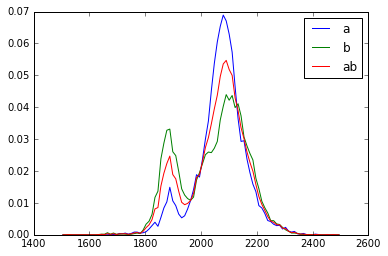

In [9]:
plt.plot(a_x_values,a_p_mass, label='a')
plt.plot(b_x_values,b_p_mass, label='b')
plt.plot(ab_x_values,ab_p_mass, label='ab')
plt.legend()

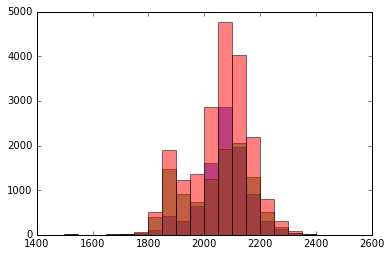

In [11]:
plt.hist(data_a, bins=20, range=(1500, 2500), alpha=0.5);
plt.hist(data_b, bins=20, range=(1500, 2500), alpha=0.5);
plt.hist(np.concatenate((data_a, data_b)), bins=20, range=(1500, 2500), alpha=0.5);

### Derive jensen shannon divergence / distance

In [12]:
def jensenshannon(data, range_min=None, range_max=None, base=2, weights=None):
    
    if range_min is None:
        data_mins = [np.nanmin(m) for m in data]
        range_min = data_mins[np.argmin(data_mins)]
    
    if range_max is None:
        data_maxs = [np.nanmax(n) for n in data]
        range_max = data_maxs[np.argmax(data_maxs)]
    
    data_shapes = [k.shape[0] for k in data]
    bins = int(np.round(data_shapes[np.argmin(data_shapes)]/100))
    p_mass = np.zeros((len(data), bins))
    
    combined_data = []
    for i in range(len(data)):
        p_mass[i], _ = prob_mass_function(data[i], bins, range_min, range_max)
        combined_data += list(data[i])
        
    p_mass_combined, _ = prob_mass_function(np.asarray(combined_data), bins, range_min, range_max)
    
    shannon_entropy = [sp.stats.entropy(p_mass[j], base=base) for j in range(p_mass.shape[0])]
    shared_shannon_entropy = sp.stats.entropy(p_mass_combined, base=base)
    
    if weights is None:
        weights = 1/len(data)
        
    shannon_entropy = np.asarray(shannon_entropy) * np.asarray(weights)
    
    jsdivergence = shared_shannon_entropy - np.sum(shannon_entropy)
    
    jsdistance = np.sqrt(jsdivergence)
    
    return jsdivergence, jsdistance

### Test on fake data

In [15]:
fake_1 = np.random.normal(0, 1, size=(1000,))
fake_2 = np.random.normal(1, 1, size=(1000,))
fake_3 = np.random.normal(5, 2, size=(1000,))

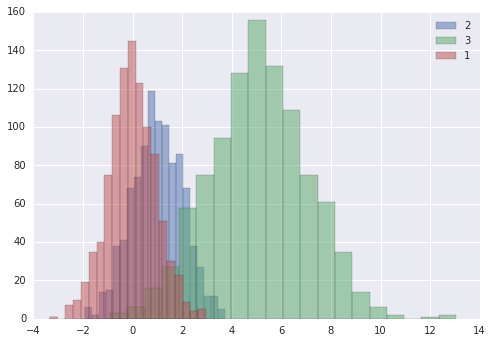

In [16]:
import seaborn as sns
plt.hist(fake_2, bins=20, label='2', alpha=0.5);
plt.hist(fake_3, bins=20, label='3', alpha=0.5);
plt.hist(fake_1, bins=20, label='1', alpha=0.5);
plt.legend()

In [17]:
jsdiv, jsdist = jensenshannon([fake_1, fake_2])
print '1 vs 2', jsdiv, jsdist

1 vs 2 0.16122521117 0.401528593215


In [18]:
jsdiv, jsdist = jensenshannon([fake_1, fake_3])
print '1 vs 3', jsdiv, jsdist

1 vs 3 0.816102336303 0.903383825571


In [19]:
jsdiv, jsdist = jensenshannon([fake_2, fake_3])
print '2 vs 3', jsdiv, jsdist

2 vs 3 0.672521393408 0.82007401703


In [20]:
jsdiv, jsdist = jensenshannon([fake_1, fake_2, fake_3])
print '1,2,3', jsdiv, jsdist

1,2,3 0.769184797474 0.877031810982


In [21]:
jsdiv, jsdist = jensenshannon([fake_1, fake_2], range_min=-4, range_max=12)
print '1 vs 2 on whole range', jsdiv, jsdist

1 vs 2 on whole range 0.142036474642 0.376877267346


### Test on real data

In [39]:
neighbours = np.zeros_like(cluster)
neighbours[np.where(subcluster[:,4]!=0)]=1
neighbours[np.where(subcluster[:,5]!=0)]=-1

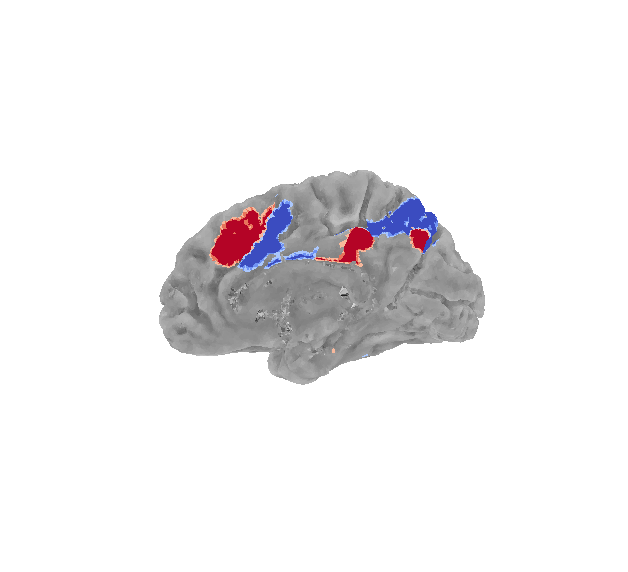

In [40]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=neighbours, threshold=1e-50, elev=180, azim=180, bg_map=sulc, figsize=(11,10))

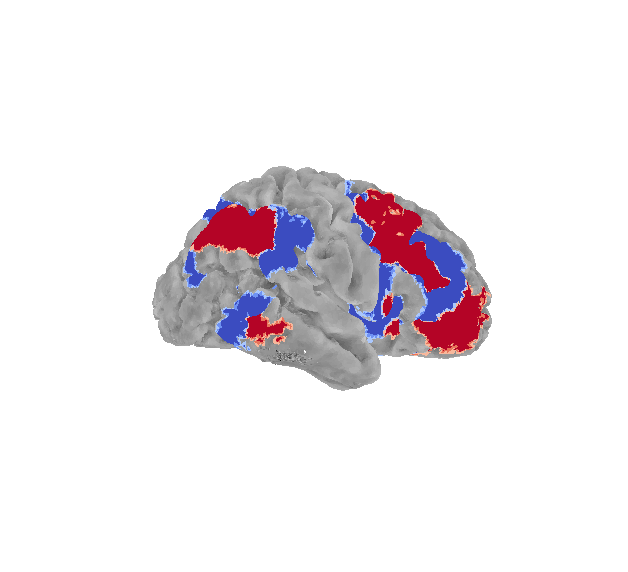

In [41]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=neighbours, threshold=1e-50, elev=180, azim=0, bg_map=sulc, figsize=(11,10))

In [50]:
direct_neighbours=np.zeros_like(cluster)
direct_neighbours[np.where(subcluster[:,4]==1)]=1
direct_neighbours[np.where(subcluster[:,4]==3)]=1
direct_neighbours[np.where(subcluster[:,5]==1)]=-1

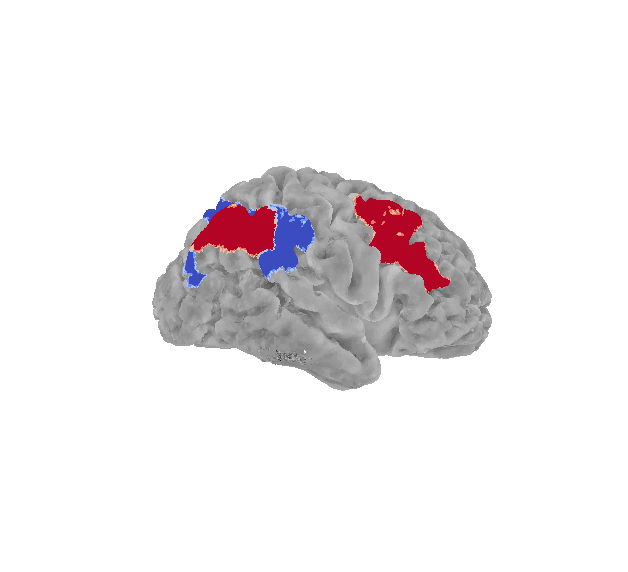

In [51]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=direct_neighbours, threshold=1e-50, elev=180, azim=0, bg_map=sulc, figsize=(11,10))

In [52]:
jsdiv, jsdis = jensenshannon([t1_avg[np.where(cluster==4)], t1_avg[np.where(cluster==5)]],
                              range_min=1500, range_max=2500)
print 'cluster 4 vs 5', jsdiv, jsdis

cluster 4 vs 5 0.0677631147277 0.260313493173


In [53]:
jsdiv, jsdis = jensenshannon([t1_avg[np.where(subcluster[:,4]==1)], t1_avg[np.where(subcluster[:,5]==1)]],
                              range_min=1500, range_max=2500)
print 'cluster 4_1 vs 5_1', jsdiv, jsdis

cluster 4_1 vs 5_1 0.168005987057 0.409885334036


In [59]:
jsdiv, jsdis = jensenshannon([t1_avg[np.where(subcluster[:,4]==1)], t1_avg[np.where(subcluster[:,4]==3)]],
                              range_min=1500, range_max=2500)
print 'cluster 4_1 vs 4_3', jsdiv, jsdis

cluster 4_1 vs 4_3 0.223449300951 0.472704242577


In [71]:
neighbours = np.zeros_like(cluster)
neighbours[np.where(subcluster[:,4]!=0)]=1
neighbours[np.where(subcluster[:,1]!=0)]=-1

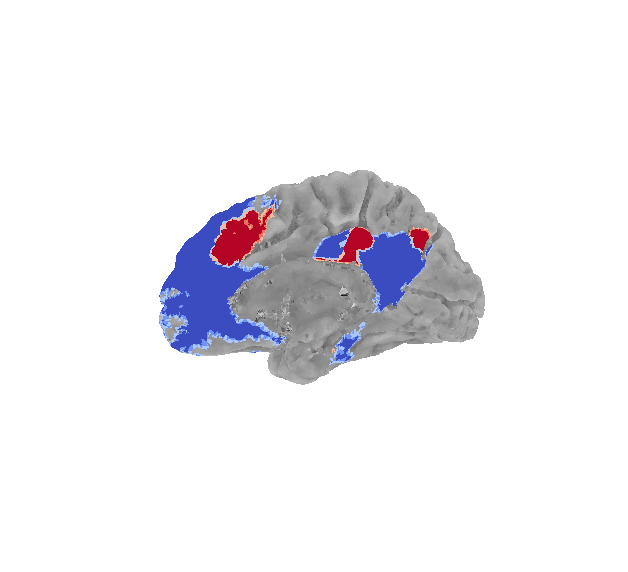

In [72]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=neighbours, threshold=1e-50, elev=180, azim=180, bg_map=sulc, figsize=(11,10))

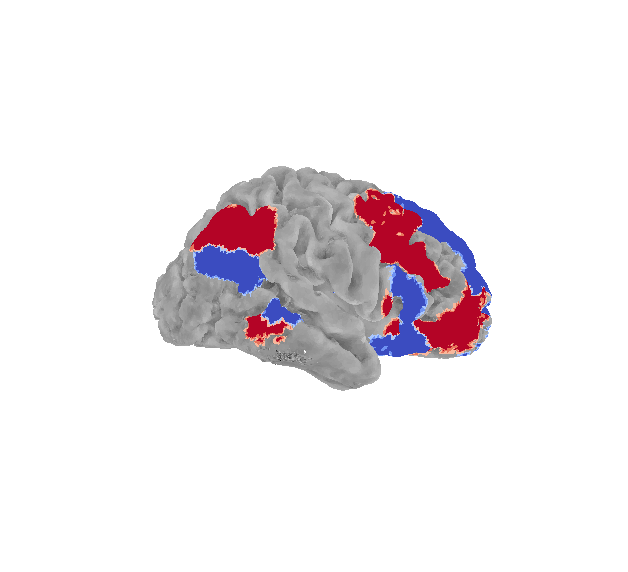

In [73]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=neighbours, threshold=1e-50, elev=180, azim=0, bg_map=sulc, figsize=(11,10))

In [74]:
direct_neighbours=np.zeros_like(cluster)
direct_neighbours[np.where(subcluster[:,4]==1)]=1
direct_neighbours[np.where(subcluster[:,4]==3)]=1
direct_neighbours[np.where(subcluster[:,1]==2)]=-1

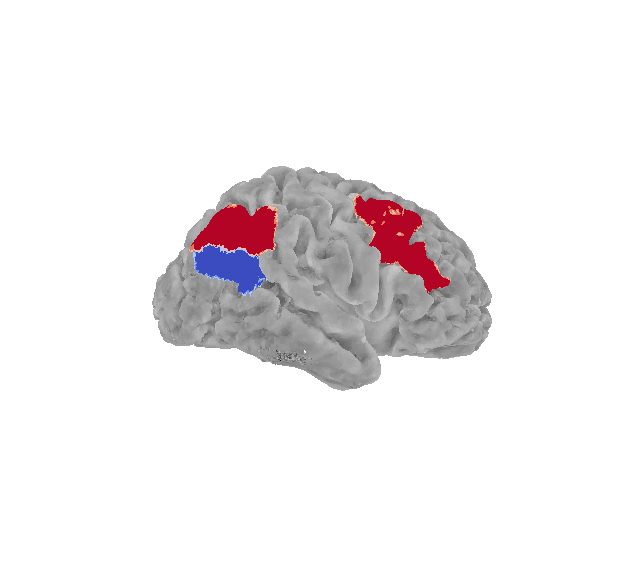

In [75]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=direct_neighbours, threshold=1e-50, elev=180, azim=0, bg_map=sulc, figsize=(11,10))

In [76]:
jsdiv, jsdis = jensenshannon([t1_avg[np.where(subcluster[:,4]==1)], t1_avg[np.where(subcluster[:,4]==3)]],
                              range_min=1500, range_max=2500)
print 'cluster 4_1 vs 4_3', jsdiv, jsdis

cluster 4_1 vs 4_3 0.223449300951 0.472704242577


In [77]:
jsdiv, jsdis = jensenshannon([t1_avg[np.where(subcluster[:,4]==1)], t1_avg[np.where(subcluster[:,1]==2)]],
                              range_min=1500, range_max=2500)
print 'cluster 4_1 vs 1_2', jsdiv, jsdis

cluster 4_1 vs 1_2 0.235695651408 0.485484965172


In [78]:
jsdiv, jsdis = jensenshannon([t1_avg[np.where(cluster==4)], t1_avg[np.where(cluster==1)]],
                              range_min=1500, range_max=2500)
print 'cluster 4 vs 1', jsdiv, jsdis

cluster 4 vs 1 0.0720157611317 0.268357524828
